## Macroeconomic trend showing

EXPLANATION: following will be done analysis of data gotten by Eurostat using custom code created. The main of this notebook is to show macroeconomic data collocted, in a way that could be immediatly readable and also customisable. The code has been showed entirely, so you can use also for other projects as well.

PURPOSE OF THIS ANALYSIS: summarise the macroeconomic trend in a readable and customizable way


NOTE: the entire analysis has been divided in three different analysis steps
1. machine learning applied to find outliers in entire dataset and analyze them
2. analyise data by time column (year) and country --> *will be treated here*
3. lag analysis by using all possible variables

### SetUp

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Read datasets

In [3]:
# read datasets by google drive
def read_gdrive_to_df(file_id):
    """
    Read an Excel file from Google Drive using its file ID and return a DataFrame.
    """
    base_url = f'https://drive.google.com/file/d/{file_id}/view?usp=sharing'
    download_url = 'https://drive.google.com/uc?id=' + base_url.split('/')[-2]
    return pd.read_excel(download_url, index_col=0)

# File IDs
df_normalize_link = '1hFZkvm_r3arVSv-VyUzCOStub9KLupHk'
df_mean_distance_link = '10iqaD8LEWDXpb1qKfHNNvNdVvODkW1Ap'

group1_link = '1SeBohyPghZlnyAA4m0i-jNUpsVF1IH8V'
group2_link = '1CjfgPobiWVD4I8oA8dTVLFjOpDsNbJ2J'
group3_link = '1et8qCxbgSucKb7zYkb698izsPpM2Reoa'
    
# Read files using the function
df_normalize = read_gdrive_to_df(df_normalize_link) # normalized data (all changed by previous year difference)
df_mean_distance = read_gdrive_to_df(df_mean_distance_link) # mean distance from year for each country

# Last save groups of countries
group1 = read_gdrive_to_df(group1_link)
group2 = read_gdrive_to_df(group2_link)
group3 = read_gdrive_to_df(group3_link)

### Datasets explanation
- df_normalize: data normalized (zscore) + made difference from previous data (.diff)
- df_mean_distance: by df_normalized has been calculated for each sigle country and year the distance by mean for each year compared to the total years

### Split datasets "df_normalize" and "df_mean_distance" in three groups. Each group contains specific countries with similarities.

In [4]:
# Example
group1

,country
0,Austria
1,Belgium
2,Cyprus
3,Denmark
4,Germany
5,Luxembourg
6,Malta
7,Netherlands
8,Sweden
9,Switzerland


In [5]:
# Get from 'df_mean_distance' the countries indices each group and split the dataframe
df = df_normalize.copy()
df.reset_index(drop=True, inplace=True)

df_norm_dist_group1 = df[df['country'].isin(group1['country'])]
df_norm_dist_group2 = df[df['country'].isin(group2['country'])]
df_norm_dist_group3 = df[df['country'].isin(group3['country'])]

In [6]:
# Get from 'df_mean_distance' the countries insides each group and split the dataframe
df = df_mean_distance.copy()
df.reset_index(drop=True, inplace=True)

df_mean_dist_group1 = df[df['country'].isin(group1['country'])]
df_mean_dist_group2 = df[df['country'].isin(group2['country'])]
df_mean_dist_group3 = df[df['country'].isin(group3['country'])]

## Data analysis

Pipeline:
- 1st plot: mean change during years
- 2th plot: average change for each country over the years
- 3th plot: intensity highlited dataframe with distance by mean for each year
- 4th plot: intensity distance by mean during years

### 1st plot: mean change during years

In [8]:
def plot_single_bubble_chart(df, last_col='Year', aggregation='sum'): # sum or mean
    columns_to_plot = df.columns[df.columns.get_loc(last_col) + 1:].tolist()

    MAX_BUBBLE_SIZE = 6000  # Custom
    MIN_BUBBLE_SIZE = 200    # Custom

    for column in columns_to_plot:
        plt.figure(figsize=(15, 6))

        years = df[last_col].unique()
        aggregated_values = df.groupby(last_col)[column].agg(aggregation)

        # Calculate the size of normalized bubbles
        max_aggregated_value = aggregated_values.max()
        normalized_sizes = (aggregated_values / max_aggregated_value) * (MAX_BUBBLE_SIZE - MIN_BUBBLE_SIZE) + MIN_BUBBLE_SIZE

        x = years
        y = np.ones_like(years)

        plt.scatter(x, y, s=normalized_sizes, alpha=0.6, edgecolors="w", linewidth=0.5)
        plt.yticks([])

        for i, year in enumerate(years):
            plt.annotate(f"{aggregated_values[year]:.3f}", (x[i], y[i]), ha='center', va='center')

        plt.title(f'{aggregation.capitalize()} of {column} for Each {last_col}')
        plt.xlabel(last_col)

        plt.show()

C:\Users\utente\anaconda3\Lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


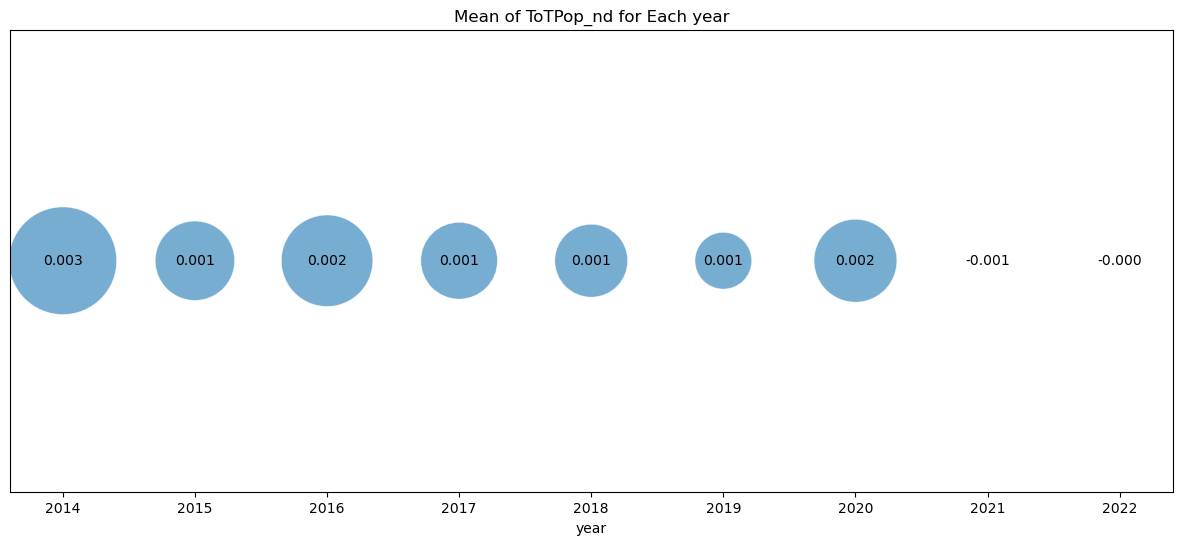

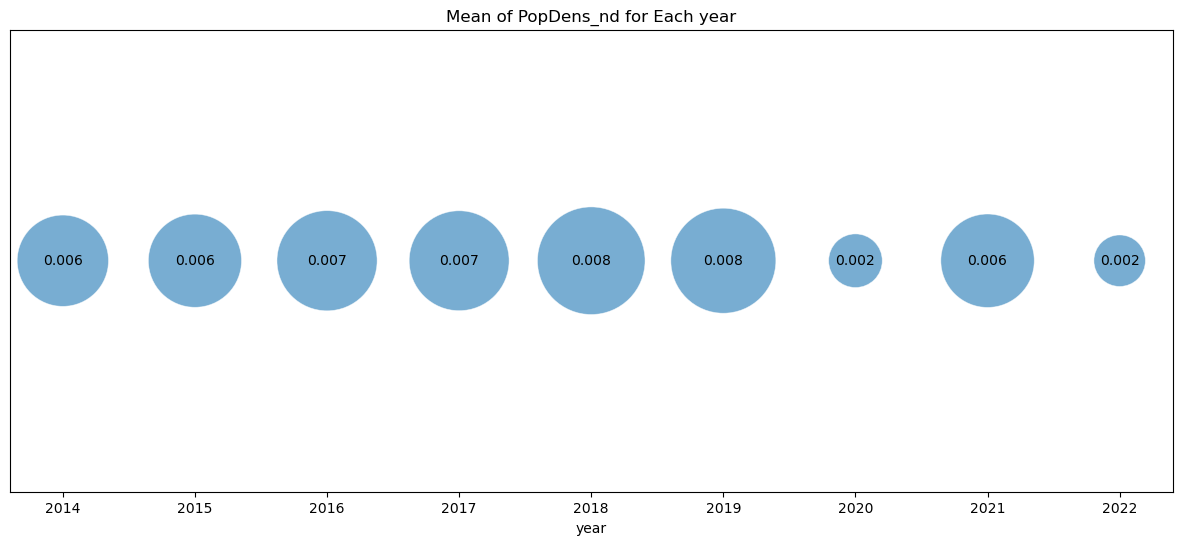

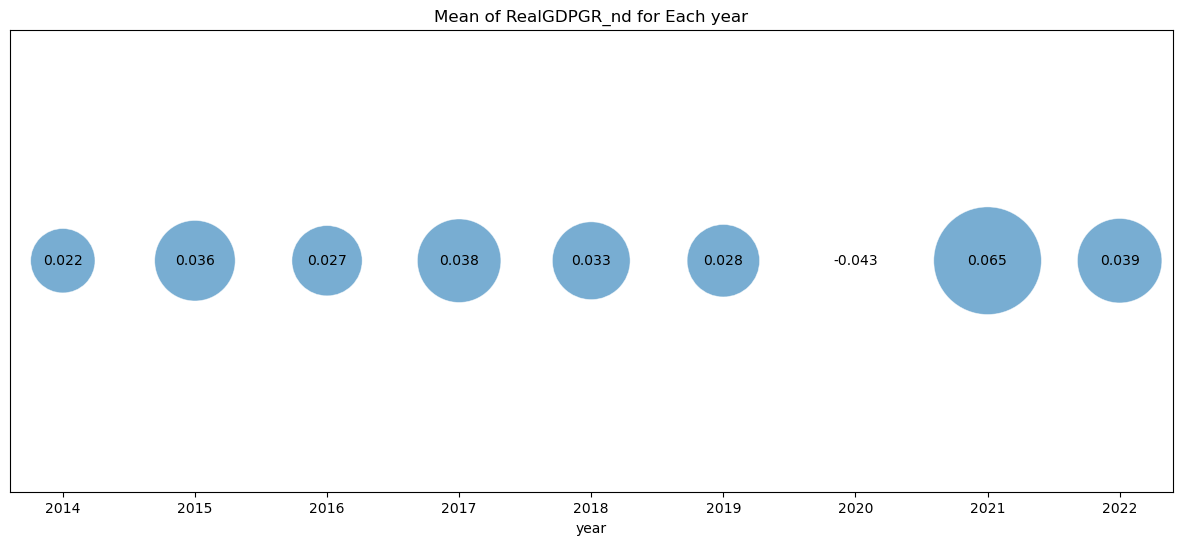

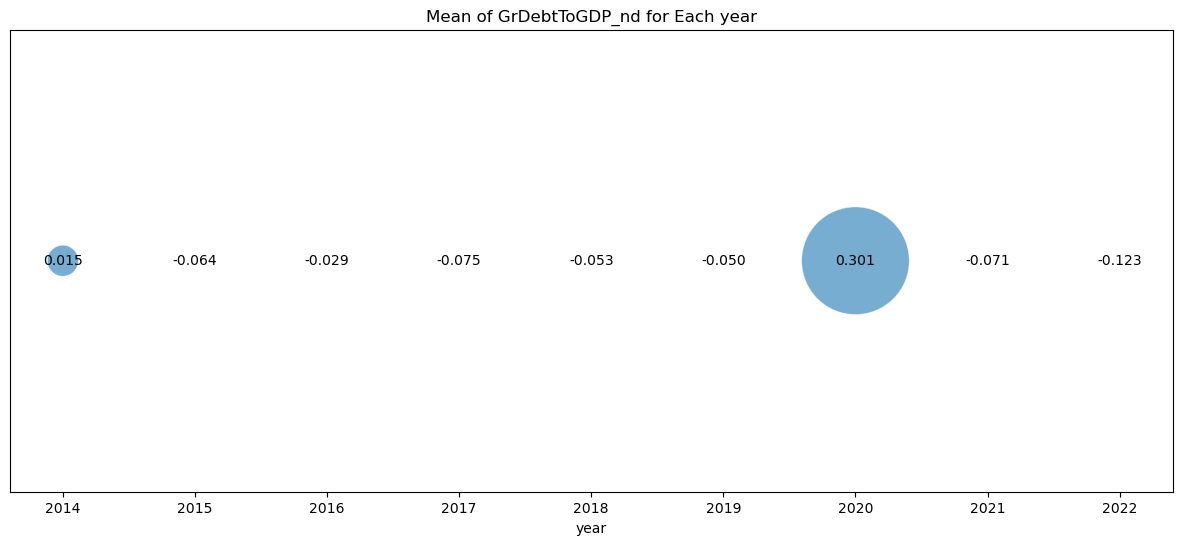

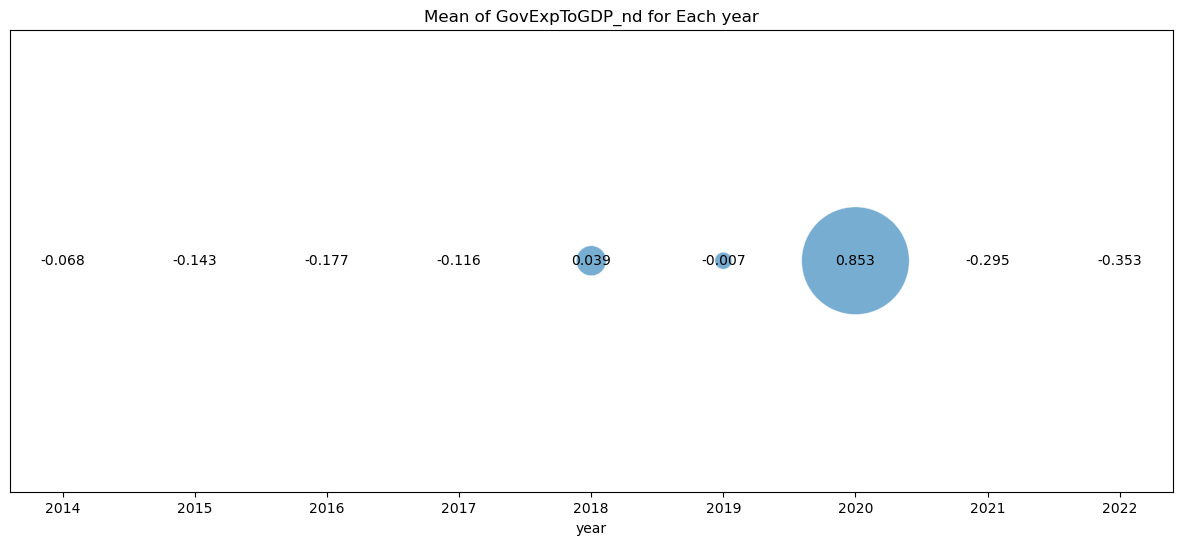

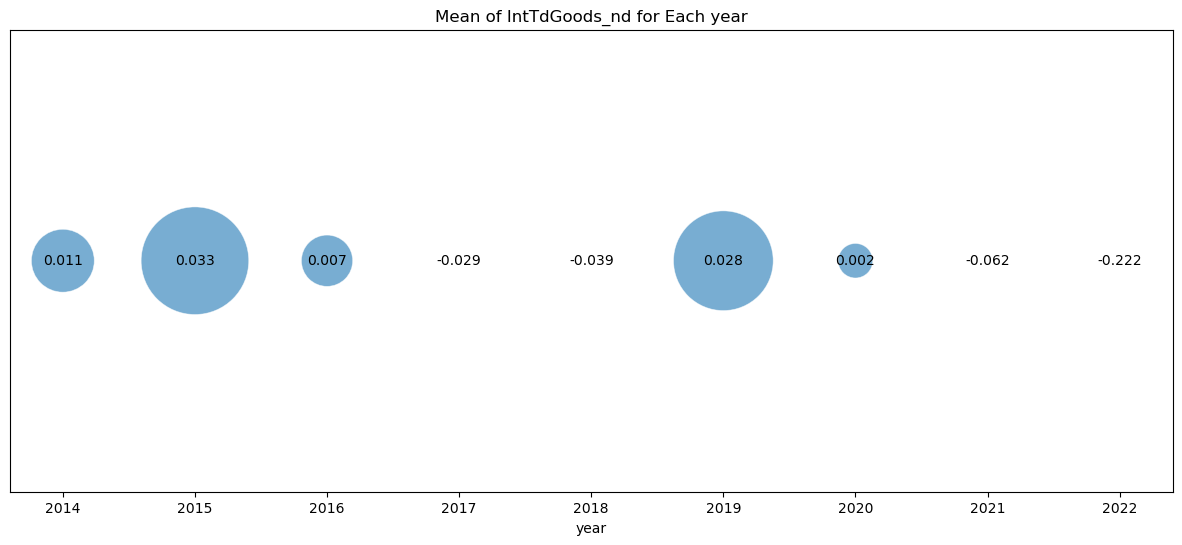

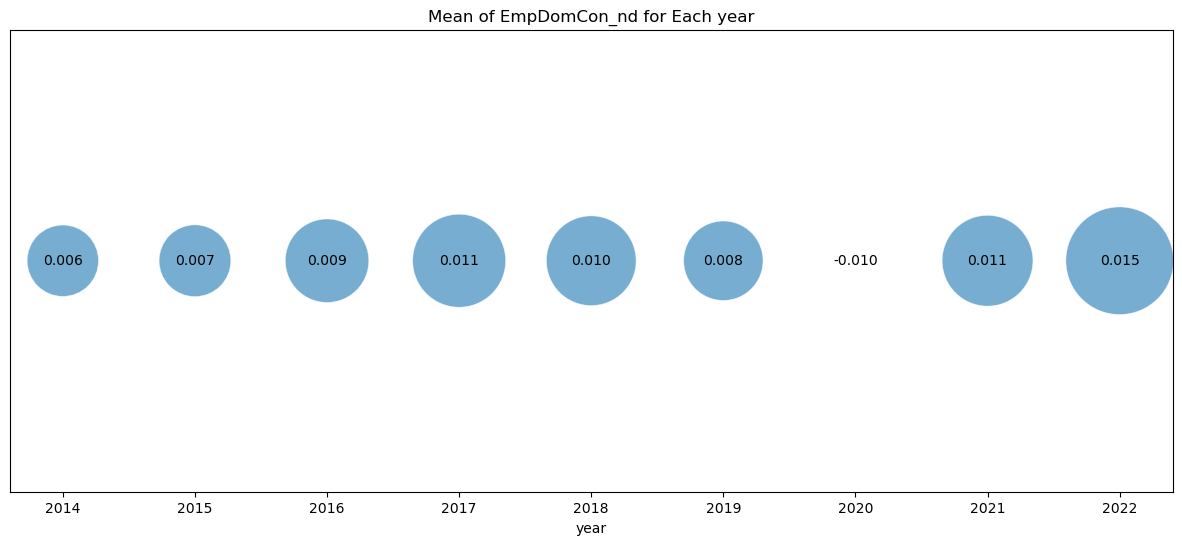

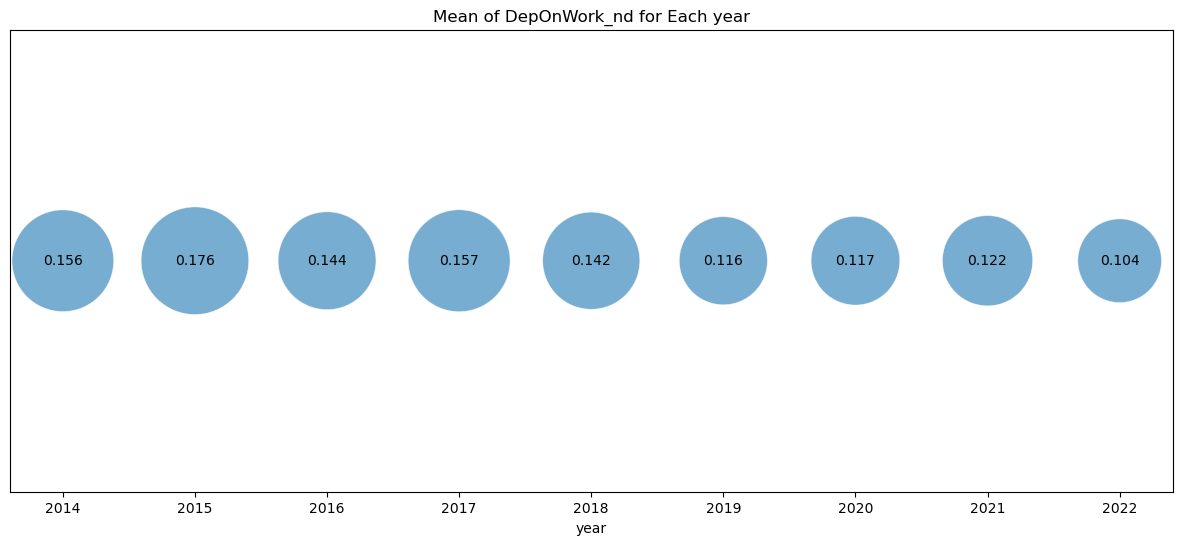

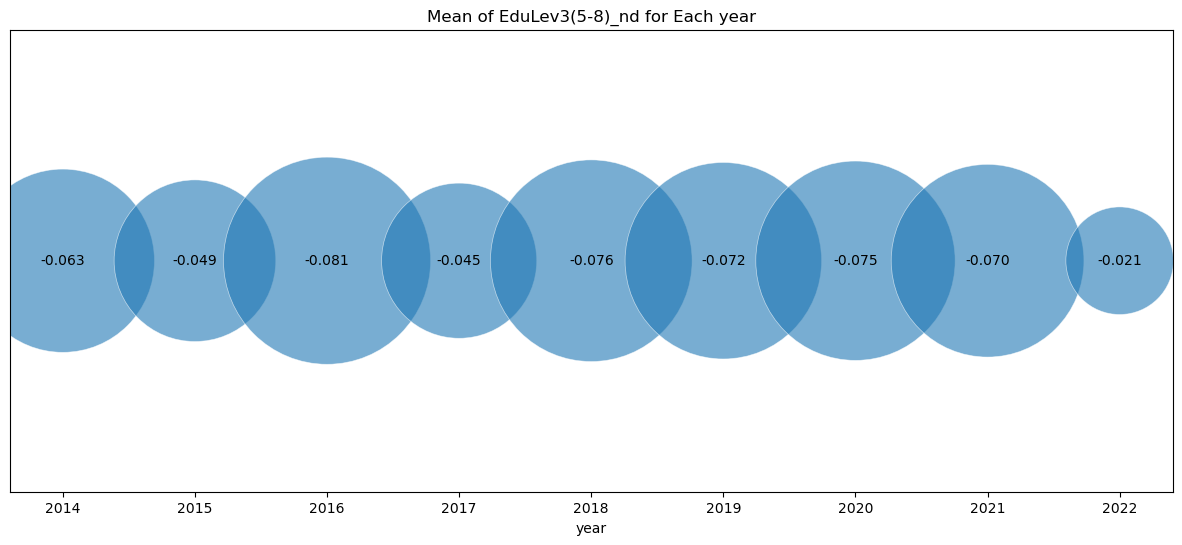

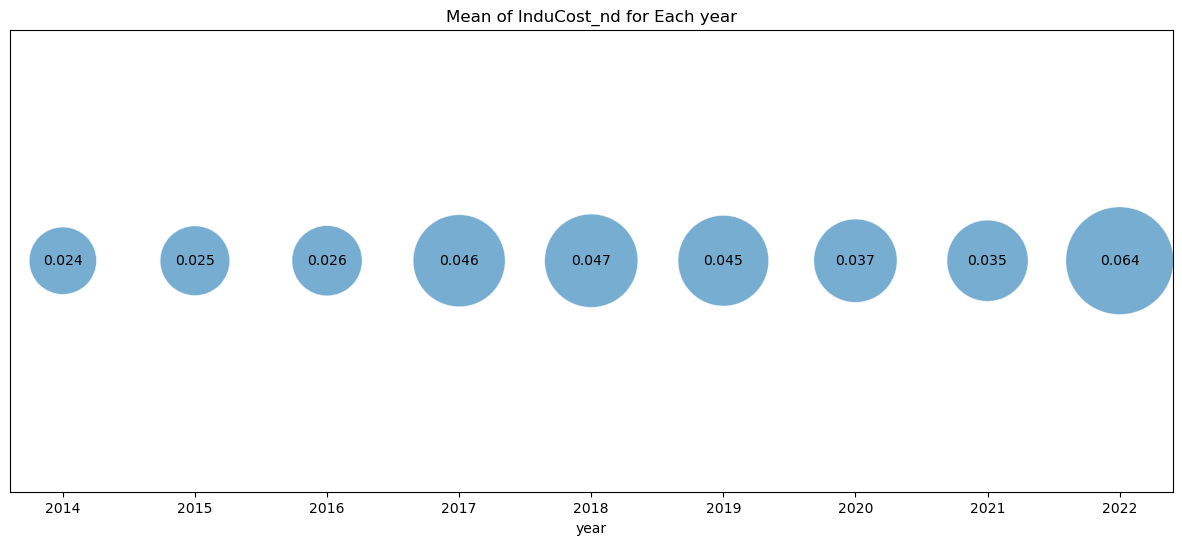

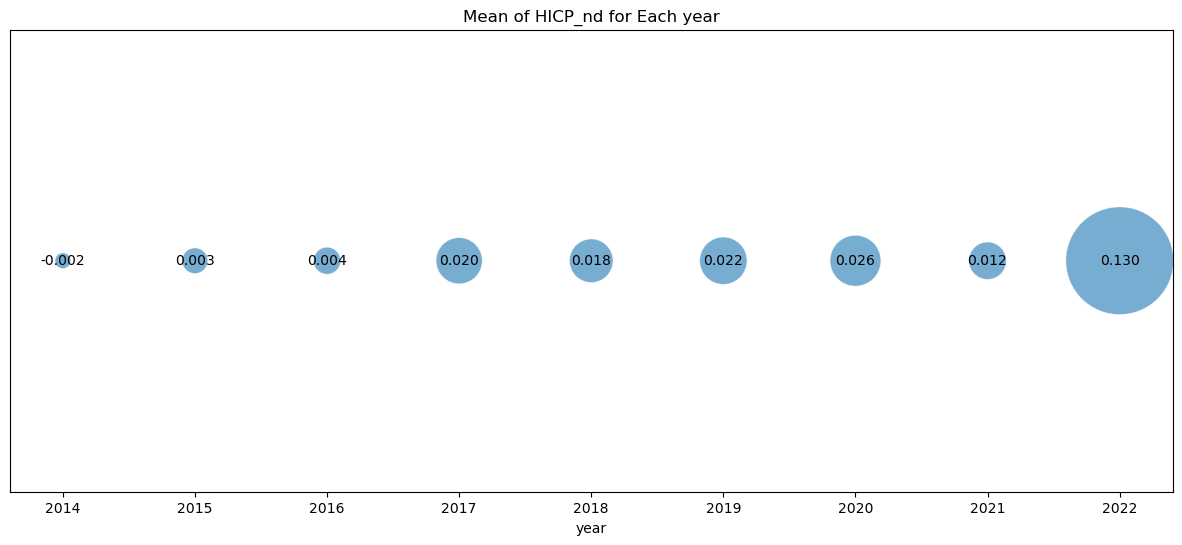

In [11]:
# Bubble Chart (overview about year situation (mean or sum) for each column number)
plot_single_bubble_chart(df_normalize, last_col='year', aggregation='mean')

### 2th plot: average change for each country over the years

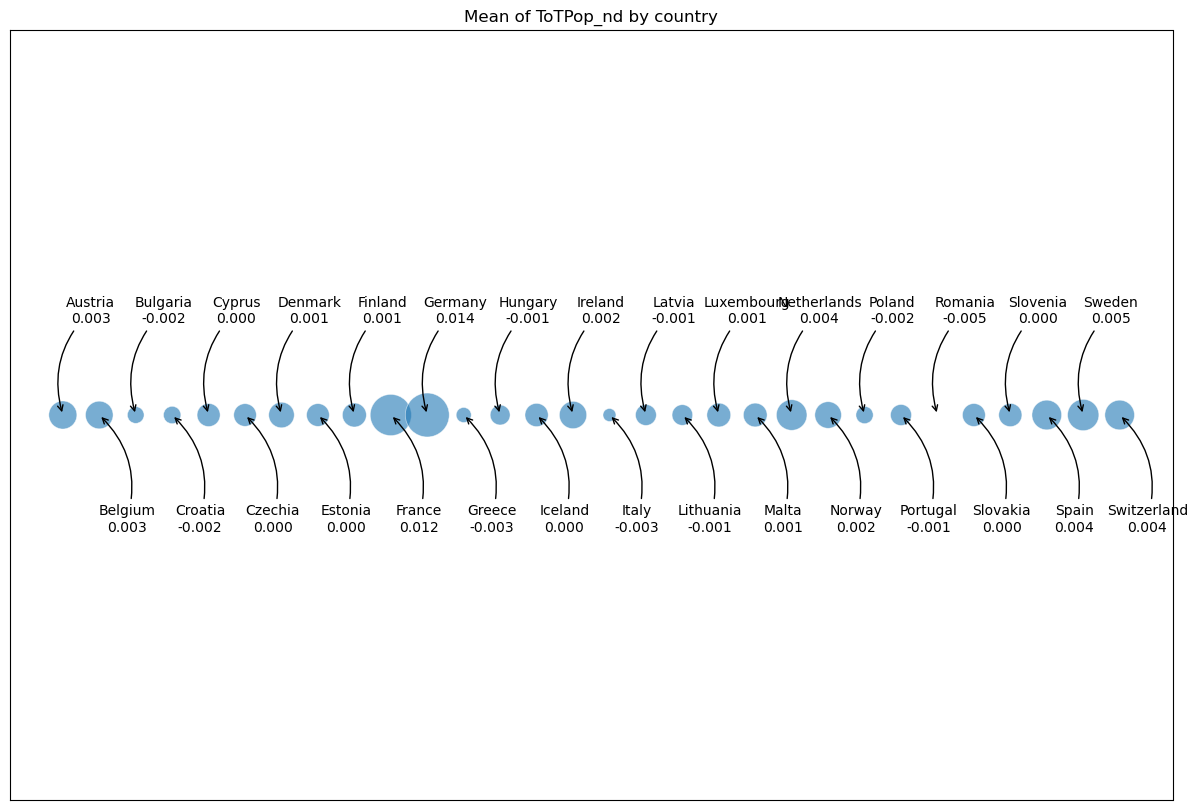

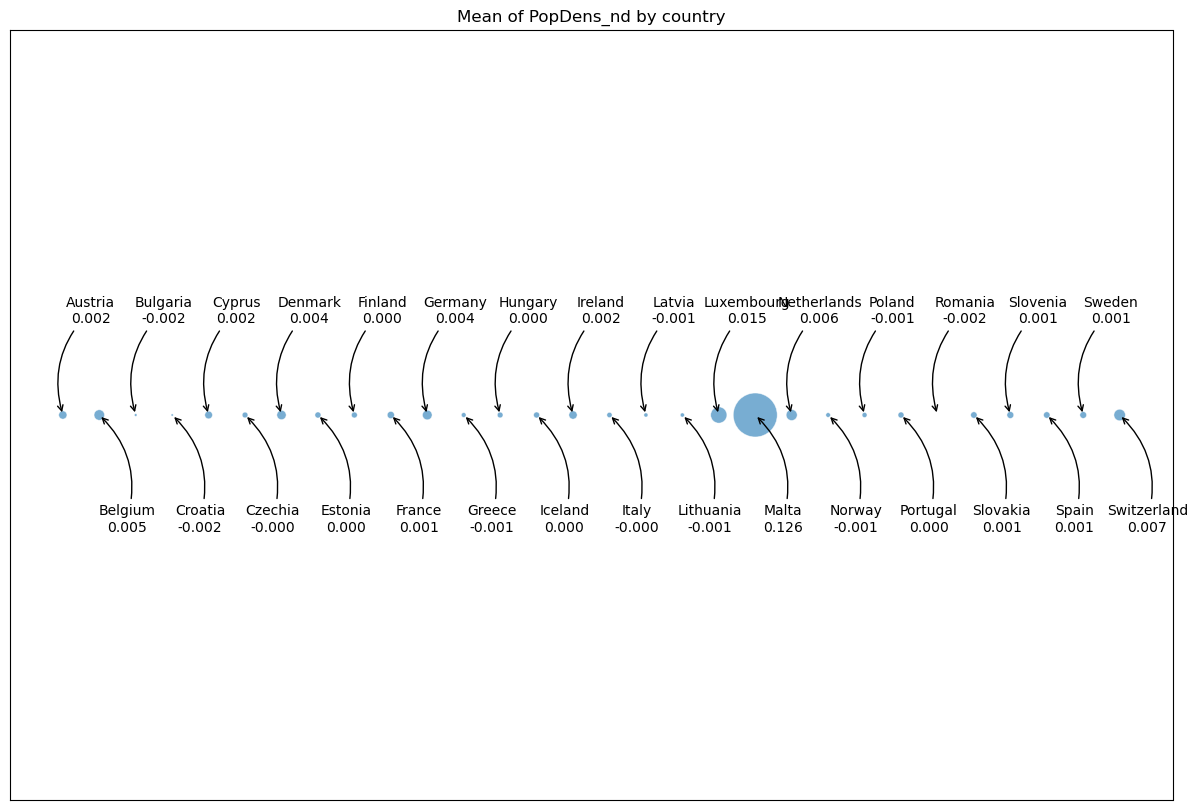

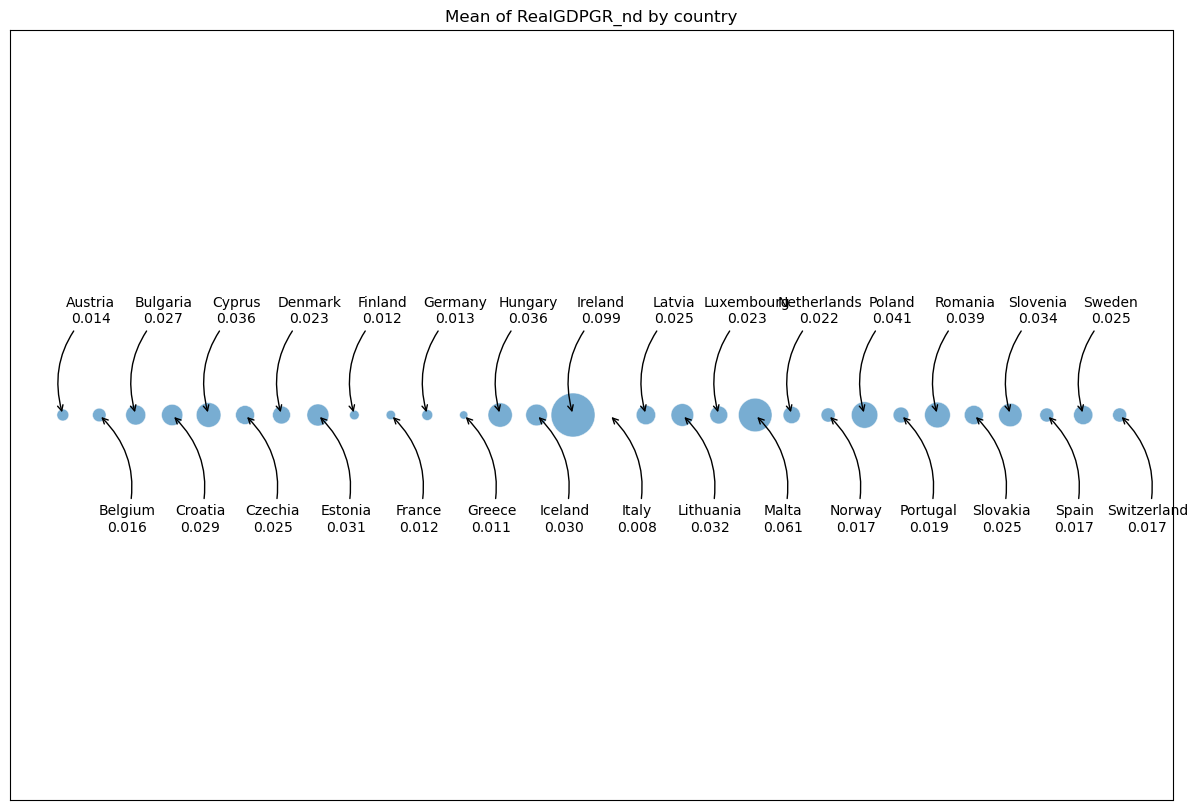

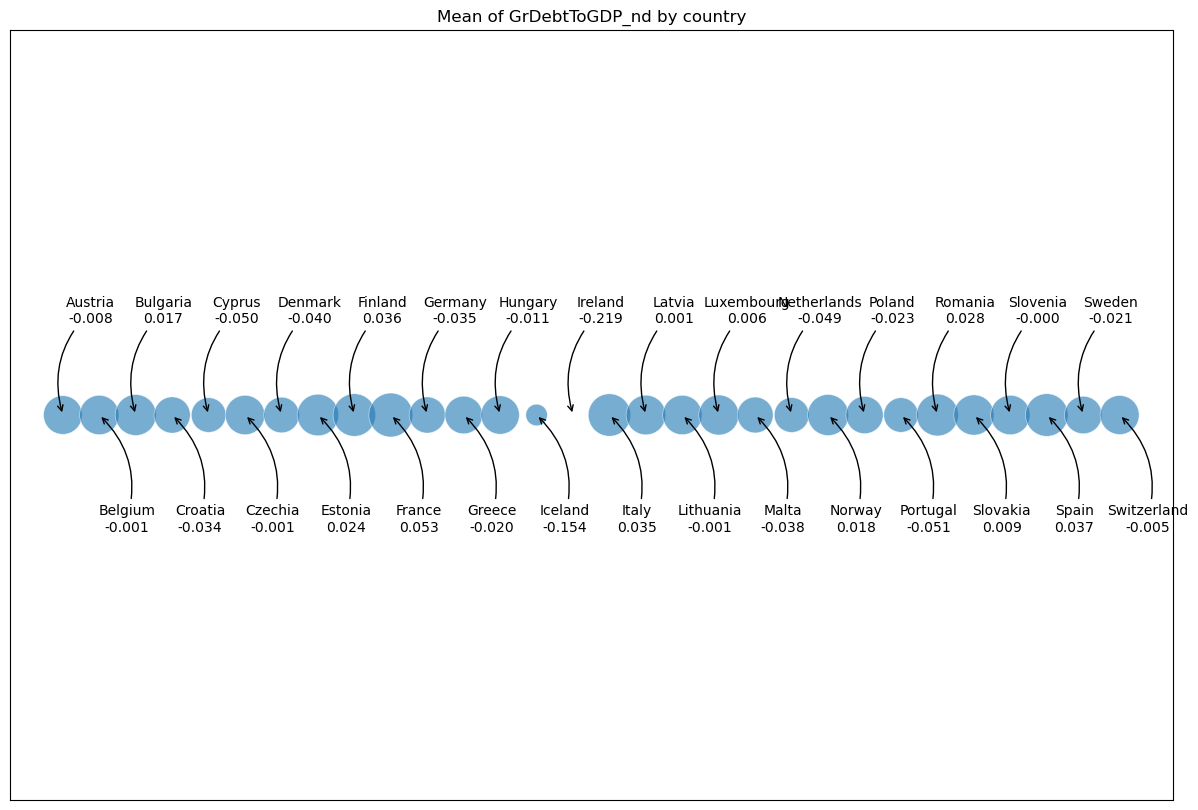

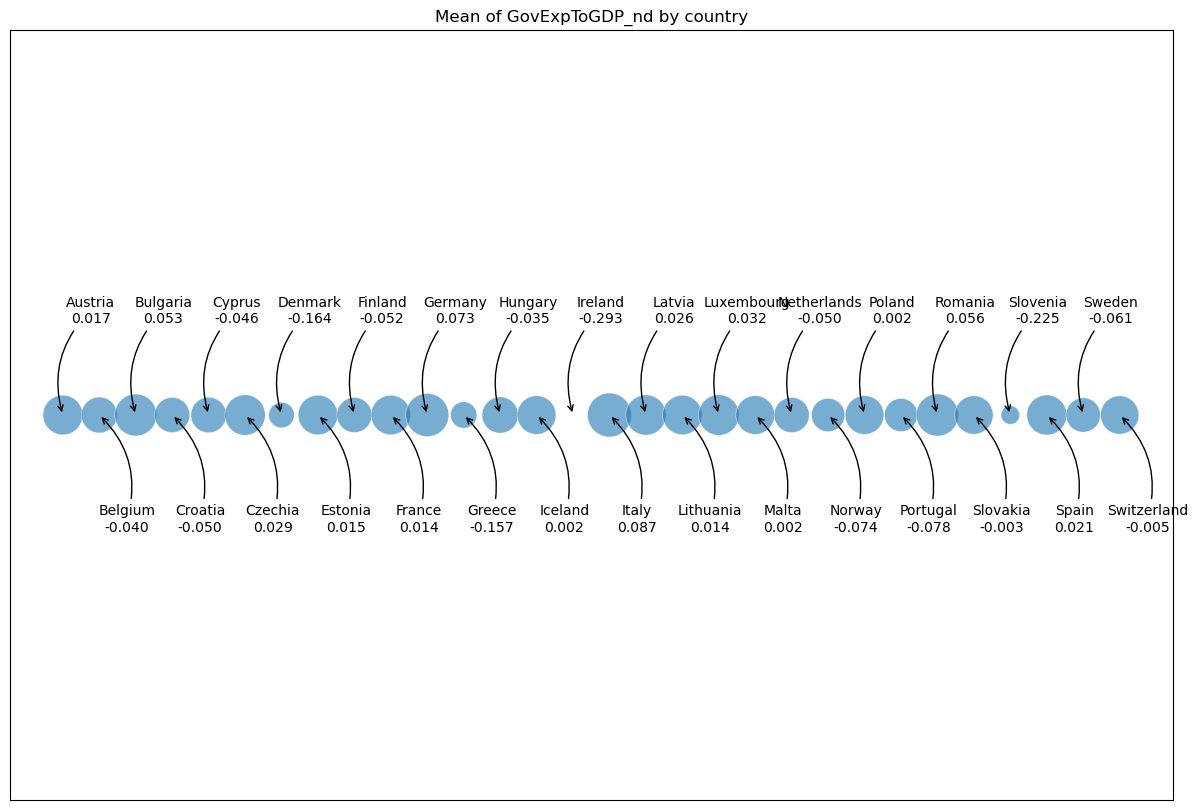

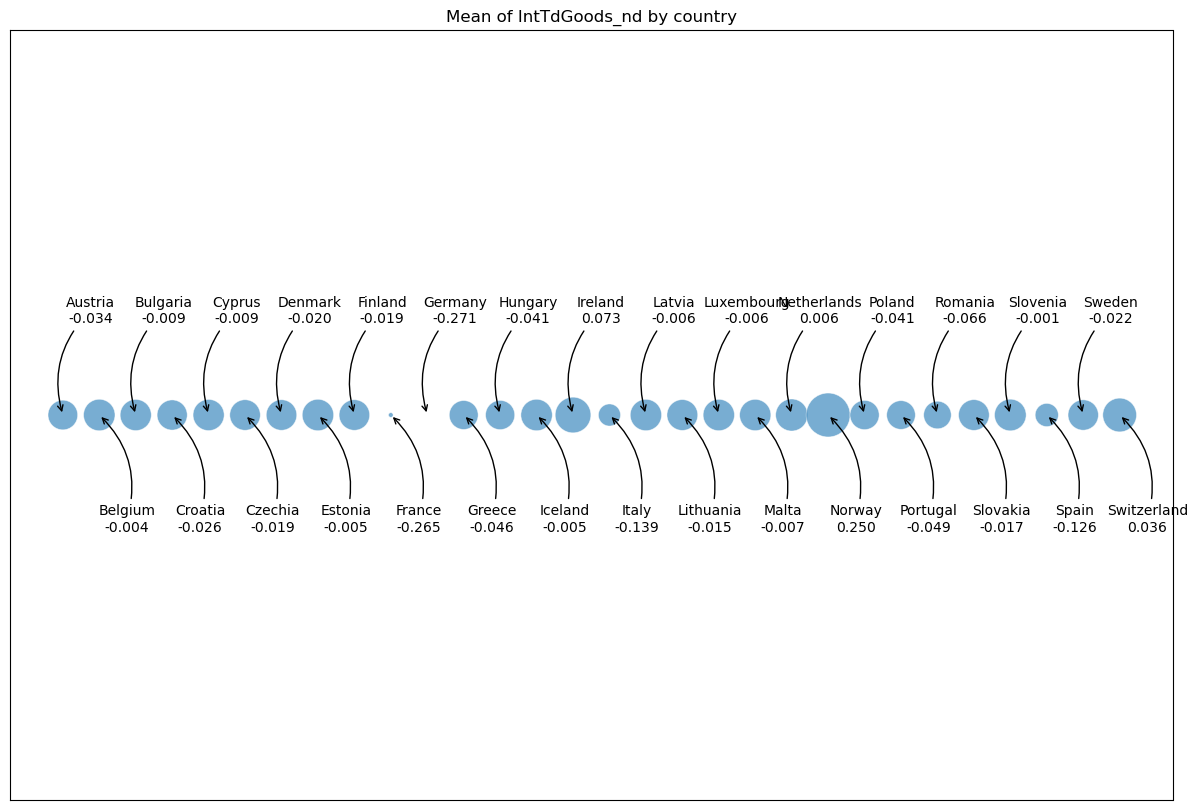

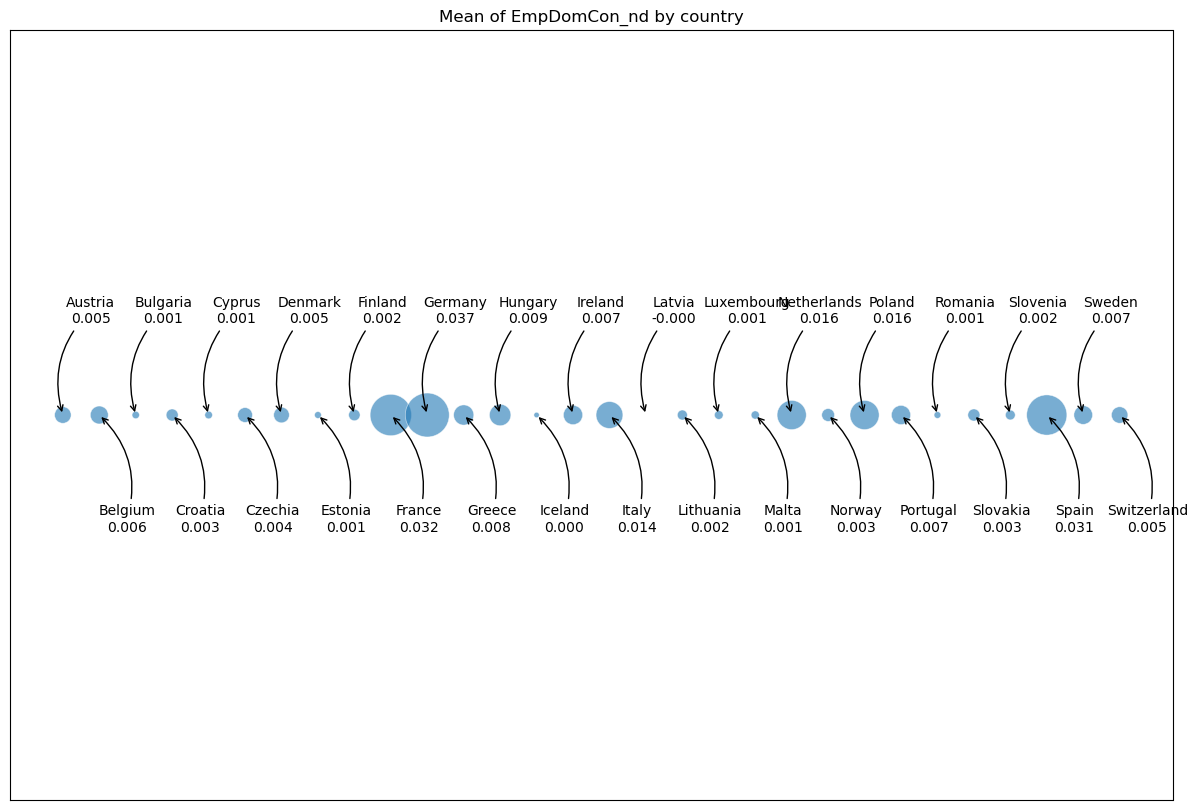

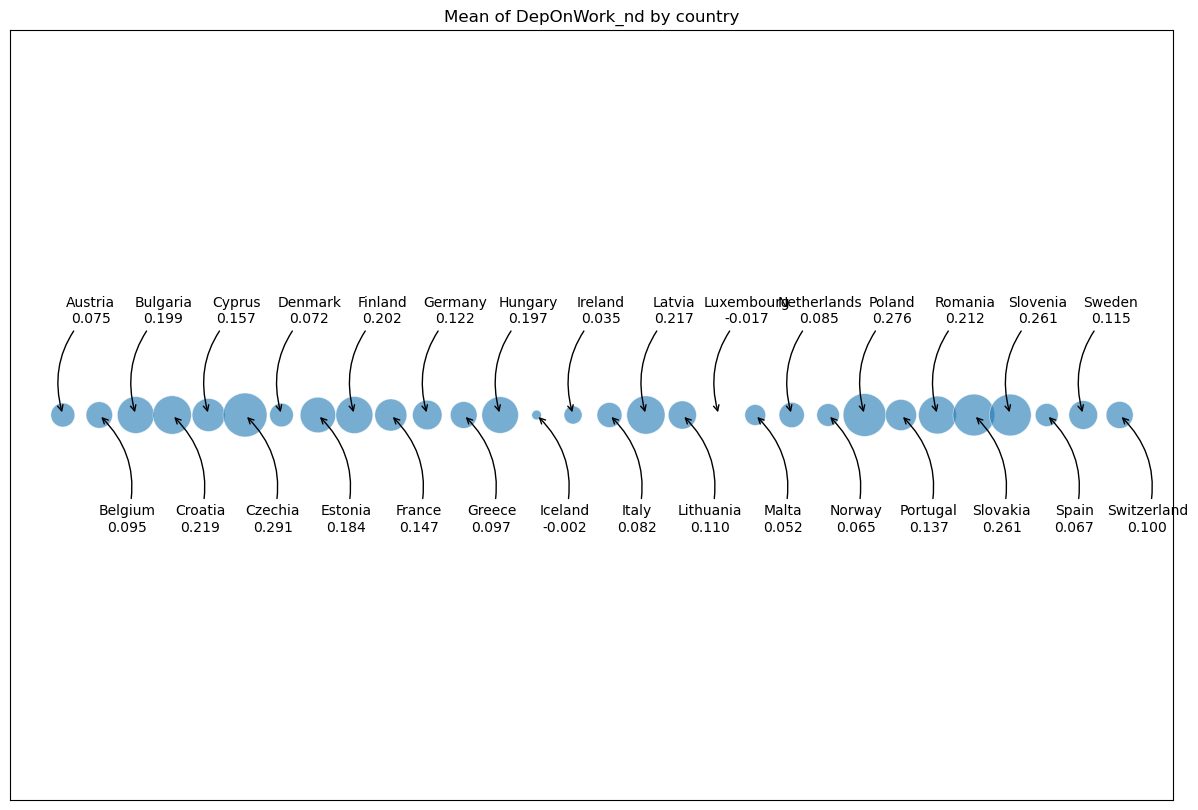

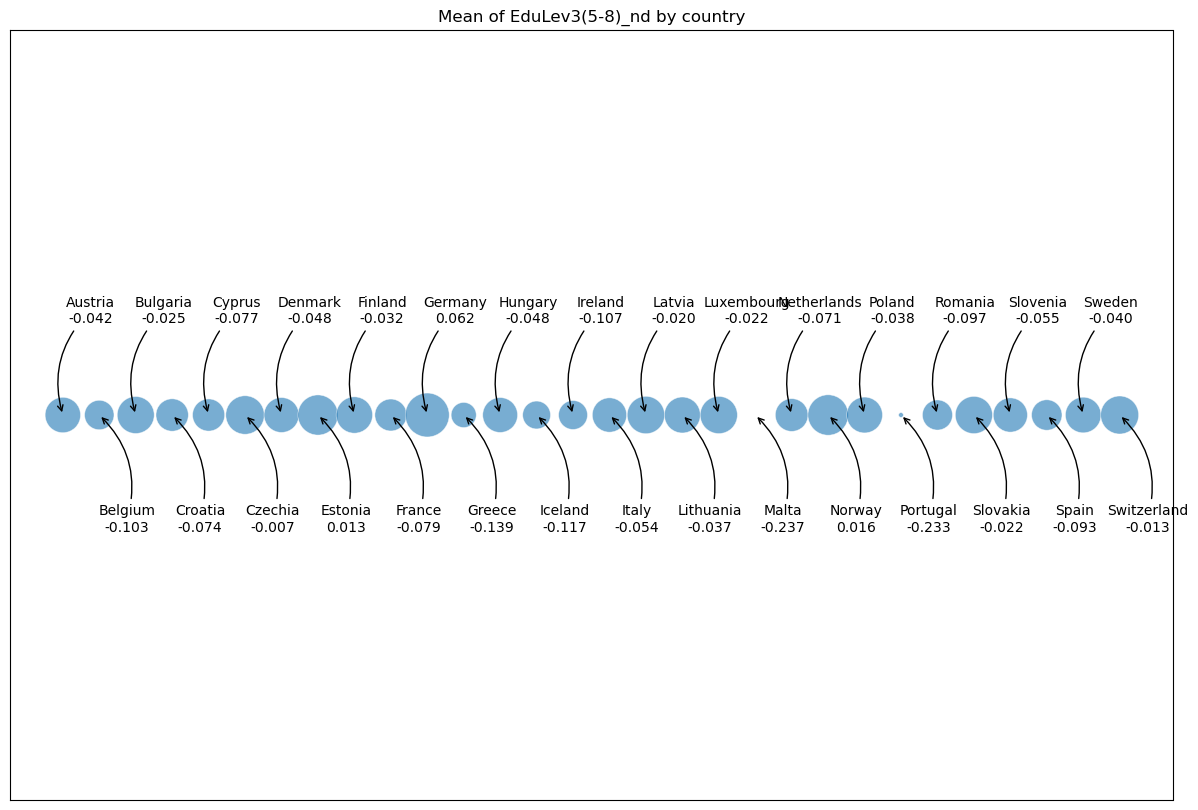

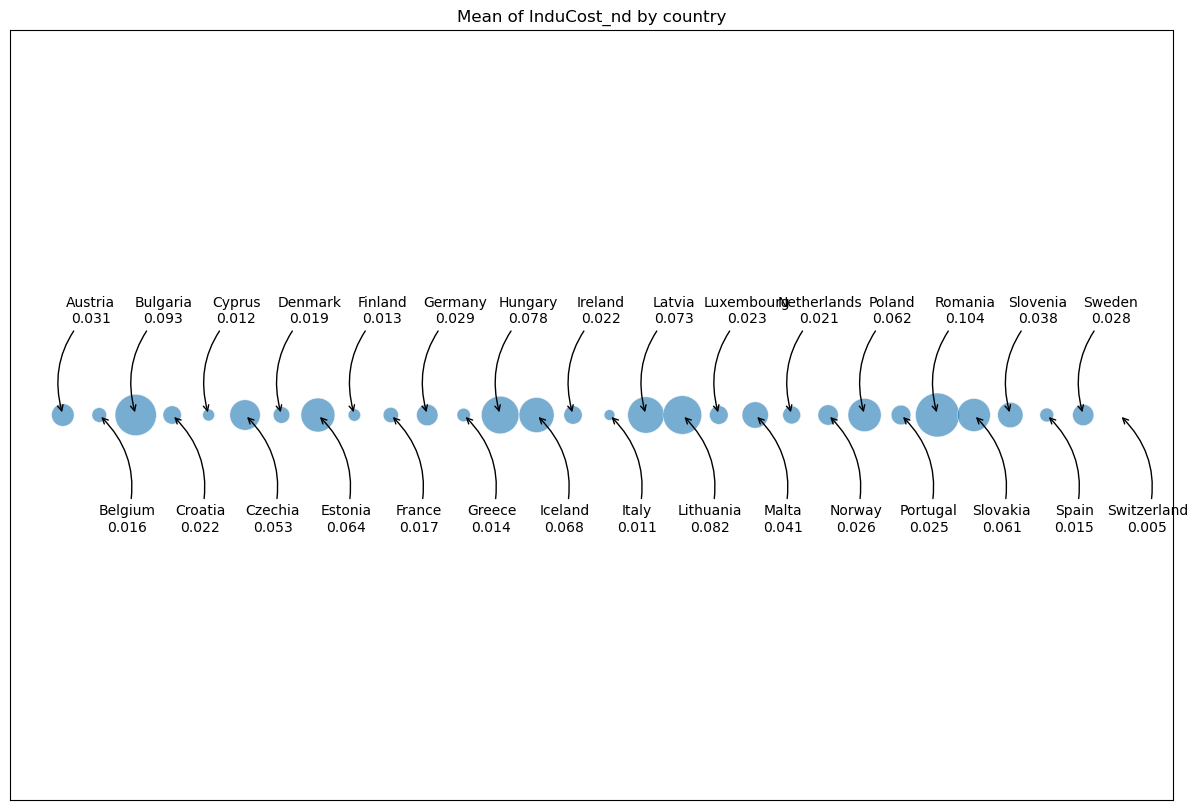

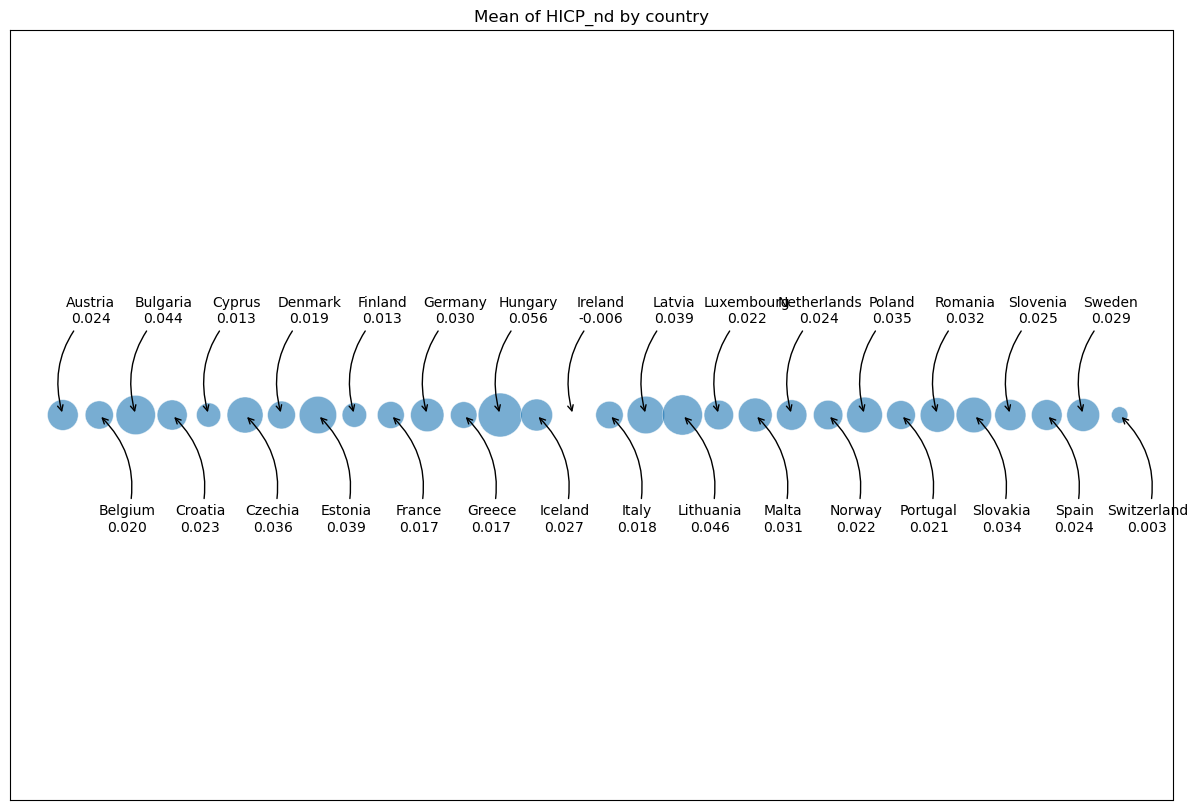

In [16]:
from adjustText import adjust_text

def plot_bubble_chart_with_arrows(df, cat_col, num_col_start, decimal_places=3, use_adjust_text=False):
    columns_to_plot = df.columns[df.columns.get_loc(num_col_start) + 1:].tolist()

    for column in columns_to_plot:
        plt.figure(figsize=(15, 10))

        grouped_data = df.groupby(cat_col)[column].mean().fillna(0)

        spacing_factor = 2.5
        x = [i * spacing_factor for i in range(len(grouped_data))]
        
        y = [1] * len(grouped_data)

        # Scala i valori tra 0 e 10000 basandosi sul minimo e massimo valore della colonna
        min_val = grouped_data.min()
        max_val = grouped_data.max()
        sizes = ((grouped_data - min_val) / (max_val - min_val)) * 1000
        bubbles = plt.scatter(x, y, s=sizes, alpha=0.6, edgecolors="w", linewidth=0.5)

        plt.yticks([])  
        plt.xticks([])

        if use_adjust_text:
            texts = []
            for i, (index, value) in enumerate(grouped_data.items()):
                bubble_coords = bubbles.get_offsets()[i]
                texts.append(plt.text(bubble_coords[0], bubble_coords[1], f"{index}\n{value:.{decimal_places}f}", ha='center', va='center'))
            
            adjust_text(texts, arrowprops=dict(arrowstyle="->", color='red'))
        else:
            for i, (index, value) in enumerate(grouped_data.items()):
                bubble_coords = bubbles.get_offsets()[i]
                if i % 2 == 0:
                    vert_offset = 75
                else:
                    vert_offset = -75
                plt.annotate(f"{index}\n{value:.{decimal_places}f}",
                             bubble_coords,
                             xytext=(20, vert_offset), textcoords='offset points',
                             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3"),
                             ha='center', va='center')
        
        plt.title(f'Mean of {column} by {cat_col}')
        plt.show()

# Bubble Chart (overview about country situation (mean or sum) for each column number)
plot_bubble_chart_with_arrows(df_normalize, 'country', 'year', decimal_places=3, use_adjust_text=False)

**IMPORTANT:** following will be pasted screenshot of output you will get from udf, because GitHub does not print colors mapping.

### 3th plot: custom filters and data intensity weight color applying

In [20]:
import pandas as pd

def color_nan(val):
    """
    Applies a light gray color for NaN values.
    """
    if pd.isna(val):
        return 'background-color: #D3D3D3'  # light gray
    else:
        return ''  # default (no coloring)

def financial_table_sorted(df, 
                           to_col_number='Market Cap', 
                           main_cat_col='Country',
                           sub_cat_target_col=None,
                           sort_by='P/E Ratio',
                           ascending_order=False,
                           highlight_gradient=True,
                           main_cat_filter_value=None,
                           sub_cat_filter_value=None,
                           exclude_columns=None,
                           exclude_view_columns=None
                           ):
    
    if exclude_columns is None:
        exclude_columns = []

    if exclude_view_columns is None:
        exclude_view_columns = []
    
    columns_to_plot = df.columns[df.columns.get_loc(to_col_number) + 1:]

    # Remove columns that user wants to exclude from view
    columns_to_plot = [col for col in columns_to_plot if col not in exclude_view_columns]
    
    # Filtrare il dataframe basato sui valori specificati dall'utente
    if main_cat_filter_value:
        df = df[df[main_cat_col] == main_cat_filter_value]
    
    if sub_cat_target_col and sub_cat_filter_value:
        df = df[df[sub_cat_target_col] == sub_cat_filter_value]

    # If sub_cat_target_col is specified
    if sub_cat_target_col:
        # Group by group and subgroups with observed=True to avoid the warning
        df_cat = df.groupby([main_cat_col, sub_cat_target_col], observed=True)[columns_to_plot].mean()
    else:
        # Group by group 
        df_cat = df.groupby(main_cat_col)[columns_to_plot].mean()
    
    print(f'Table sorted by: {sort_by}')
    sort_financial_df = df_cat.sort_values(by=sort_by, ascending=ascending_order)

    styled_df = sort_financial_df.style

    # Apply the gradient only if specified
    if highlight_gradient:
        for col in columns_to_plot:
            if col not in exclude_columns:
                styled_df = styled_df.background_gradient(cmap='BuGn', subset=col)

    return styled_df.map(color_nan)

In [27]:
# # Filter: df, column from witch get numeric columns, category reference, sub category (optional)
financial_table_sorted(df_normalize, to_col_number='year',
                       main_cat_col='country', # main columns
                       sub_cat_target_col='year', # sub column (optional)
                       sort_by='year',
                       ascending_order=True,
                       highlight_gradient=True,
                       main_cat_filter_value='Italy',  # Filter by specific value
                       sub_cat_filter_value=None, # Sub filter by specific value
                       exclude_columns=None, # Exclude some columns
                       exclude_view_columns=None) # Exclude viewing specific col

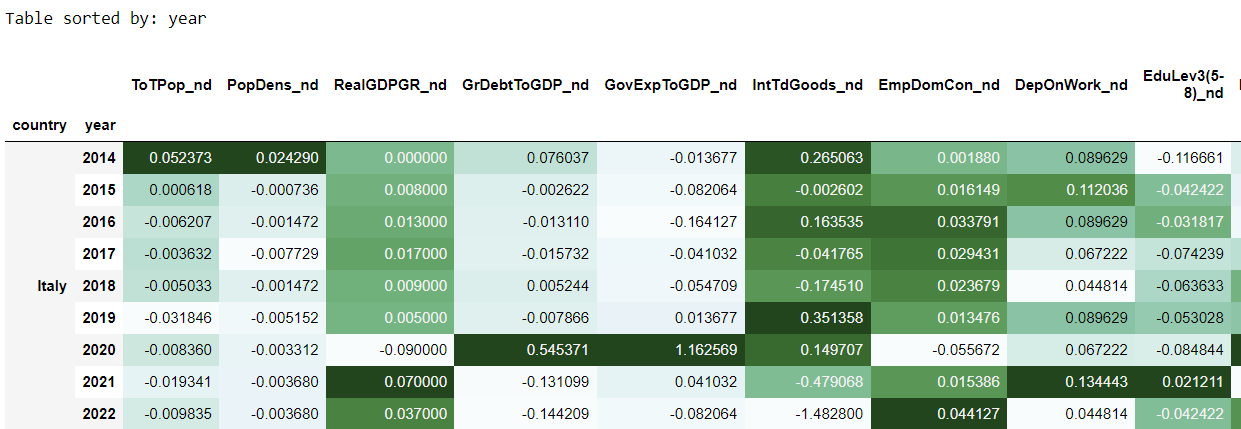

### 4th plot: dataframe with color intensity change by value size

In [23]:
def gradient_based_on_value(df, last_col='Year', exclude_columns=[], exclude_values=[]):
    
    # Find the columns to highlight
    columns_to_highlight = [col for col in df.columns[df.columns.get_loc(last_col)+1:].tolist() if col not in exclude_columns]
    
    def highlight_based_on_mean(value, mean, std_dev, min_value, max_value):
        """Colors the value based on its distance from the mean."""
        if pd.isna(value):  # If the value is NaN
            return 'background-color: AliceBlue;'
        
        elif value in exclude_values:  # If the value is in the list of values ​​to exclude
            return 'background-color: white;'
        
        elif value <= 0:  # If the value is negative or zero
            if min_value == 0:
                return f'background-color: rgb(255, 255, 255);'  # White for zero if min_value is zero
            intensity = int((value - min_value) / (0 - min_value) * 255)
            return f'background-color: rgb(255, {intensity}, {intensity});'
        
        else:  # If the value is positive
            if max_value == 0:
                return f'background-color: rgb(255, 255, 255);'  # Bianco per zero se max_value è zero
            intensity = int(255 - (value / max_value) * 255)
            return f'background-color: rgb({intensity}, 255, {intensity});'

    def style_columns(col):
        """Apply the style only to the columns of interest."""
        mean = col.mean()
        std_dev = col.std()
        min_value = col.min()
        max_value = col.max()
        return col.apply(lambda value: highlight_based_on_mean(value, mean, std_dev, min_value, max_value))

    # Apply the style only to the columns of interest
    styled_df = df.style.apply(style_columns, subset=columns_to_highlight)
    
    return styled_df

In [28]:
# Check data distribution and range of values highlithed
# Here is passed 'df_mean_distance' (check above to see what does it indicate)
styled_df = gradient_based_on_value(df_mean_distance, 'year', exclude_columns=[], exclude_values=[])
styled_df

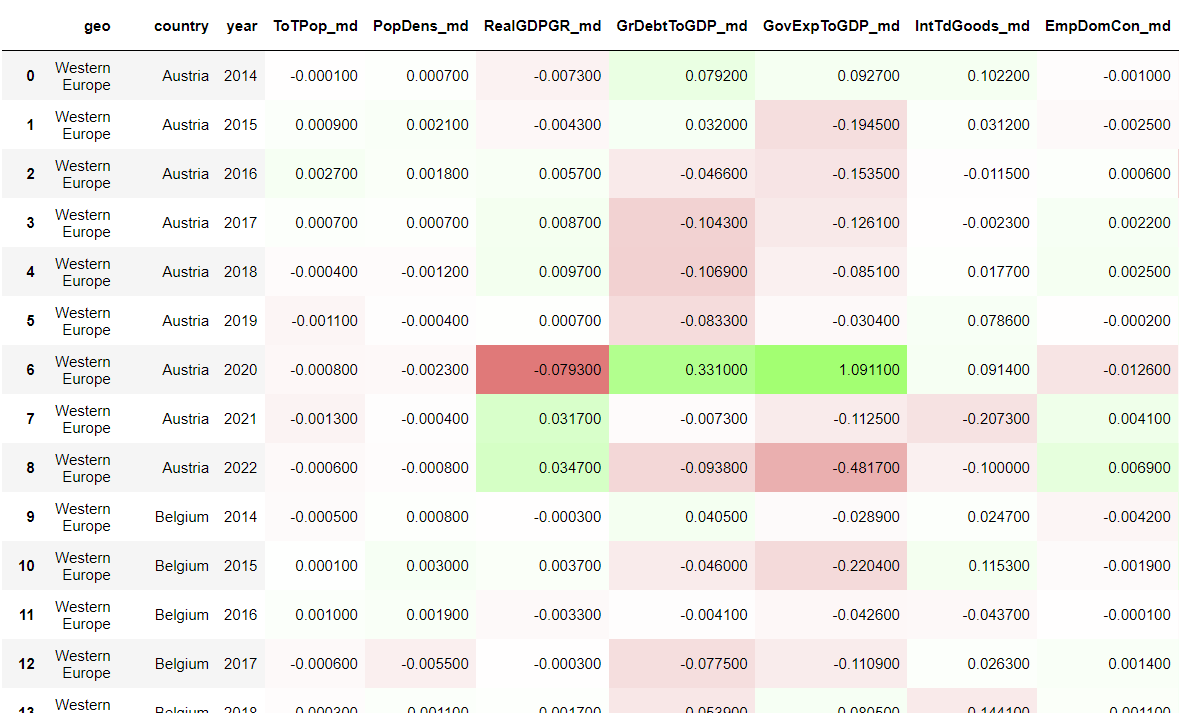